# Bayesian system identification

In [1]:
import numpy as np
import scipy
from scipy import linalg
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Algorithms
DMD, SINDy, Linear and Unscented Kalman filters

### Auxiliary functions

In [175]:
  
def _log_gaussian_density(y, mu, S):
    d = len(y)
    diff = y - mu
    try:
        c, lower = linalg.cho_factor(S, check_finite=False)
        alpha = linalg.cho_solve((c, lower), diff)
        logdet = 2 * np.sum(np.log(np.diag(c)))
    except np.linalg.LinAlgError:
        alpha = np.linalg.solve(S, diff)
        logdet = np.log(np.linalg.det(S))
    return -0.5 * (diff.T @ alpha + logdet + d * np.log(2 * np.pi))

### DMD

In [37]:
def loss_function_2(theta, t_data, y_data, f, x0):
    sol = solve_ivp(lambda t, x: f(t, x, theta),
                    (t_data[0], t_data[-1]),
                    x0,
                    t_eval=t_data,
                    method='RK45')
    x_model = sol.y.T  # (n, d)
    residuals = y_data - x_model
    return np.sum(residuals**2)

def loss_function_3(theta, y_data, f):
    residuals = np.array([y_data[i] - f(y_data[i-1], theta) for i in range(1, len(y_data))])
    return np.sum(residuals**2)

### SINDy

### Linear Kalman filter

In [176]:
def linearkalman(theta, Y, m0, P0, prior_logpdf, A_fn, H_fn, Sigma_fn, Gamma_fn):
    Y = np.asarray(Y)
    n, m = Y.shape

    log_prior = prior_logpdf(theta)
    logL = 0.0

    mk = m0.copy()
    Pk = P0.copy()

    for k in range(n):
        # Predict
        A = np.atleast_2d(A_fn(theta))
        Sigma = np.atleast_2d(Sigma_fn(theta))
        m_minus = A @ mk
        P_minus = A @ Pk @ A.T + Sigma

        # Evidence
        H = np.atleast_2d(H_fn(theta))
        Gamma = np.atleast_2d(Gamma_fn(theta))
        mu_k = H @ m_minus
        S_k = H @ P_minus @ H.T + Gamma

        yk = Y[k]
        logp = _log_gaussian_density(yk, mu_k, S_k)
        logL += logp

        # Update
        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv_HT = linalg.cho_solve((c, lower), H.T, check_finite=False)
        except np.linalg.LinAlgError:
            S_inv_HT = np.linalg.inv(S_k) @ H.T

        K = P_minus @ S_inv_HT
        innovation = yk - mu_k
        mk = m_minus + K @ innovation
        Pk = P_minus - K @ H @ P_minus
        Pk = (Pk + Pk.T) / 2.0
        Pk += 1e-8 * np.eye(Pk.shape[0])

    log_post = log_prior + logL
    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_post,
        'prediction': (mk, Pk)
    }



### Unscented Kalman Filter

In [5]:
def unscentedkalman(theta, Y, m0, P0, prior_logpdf,
                          Phi, h, Sigma_fn, Gamma_fn,
                          alpha=1e-3, beta=2.0, kappa=0.0):
    Y = np.asarray(Y)
    n, m = Y.shape
    d = m0.shape[0]
    log_prior = prior_logpdf(theta)

    mk = m0.astype(np.float64).copy()
    Pk = P0.astype(np.float64).copy()
    logL = 0.0

    lambd = alpha**2 * (d + kappa) - d
    denom = d + lambd
    w0m = lambd / denom
    w0c = w0m + (1 - alpha**2 + beta)
    wim = 1.0 / (2.0 * denom)
    sqrt_d_lamb = np.sqrt(denom)

    for k in range(n):
        # Predict
        try:
            A = np.linalg.cholesky(Pk)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(Pk + 1e-8 * np.eye(d))

        x_points = np.empty((d, 2*d + 1))
        x_points[:, 0] = mk
        for i in range(d):
            col = A[:, i]
            x_points[:, 1 + i] = mk + sqrt_d_lamb * col
            x_points[:, 1 + d + i] = mk - sqrt_d_lamb * col

        x_hat_points = np.empty_like(x_points)
        for i in range(2*d + 1):
            x_hat_points[:, i] = Phi(x_points[:, i], theta)

        m_minus = w0m * x_hat_points[:, 0] + wim * np.sum(x_hat_points[:, 1:], axis=1)
        P_minus = np.atleast_2d(Sigma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diff = x_hat_points[:, i] - m_minus
            if i == 0:
                P_minus += w0c * np.outer(diff, diff)
            else:
                P_minus += wim * np.outer(diff, diff)
        P_minus = (P_minus + P_minus.T) / 2.0

        # Measurement
        try:
            A2 = np.linalg.cholesky(P_minus)
        except np.linalg.LinAlgError:
            A2 = np.linalg.cholesky(P_minus + 1e-8 * np.eye(d))

        x_points2 = np.empty((d, 2*d + 1))
        x_points2[:, 0] = m_minus
        for i in range(d):
            col = A2[:, i]
            x_points2[:, 1 + i] = m_minus + sqrt_d_lamb * col
            x_points2[:, 1 + d + i] = m_minus - sqrt_d_lamb * col

        y_hat_points = np.empty((m, 2*d + 1))
        for i in range(2*d + 1):
            y_hat_points[:, i] = h(x_points2[:, i], theta)

        mu_k = w0m * y_hat_points[:, 0] + wim * np.sum(y_hat_points[:, 1:], axis=1)
        S_k = np.atleast_2d(Gamma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diffy = y_hat_points[:, i] - mu_k
            if i == 0:
                S_k += w0c * np.outer(diffy, diffy)
            else:
                S_k += wim * np.outer(diffy, diffy)
        S_k = (S_k + S_k.T) / 2.0

        yk = Y[k]
        logL += _log_gaussian_density(yk, mu_k, S_k)

        # Update
        C_k = np.zeros((d, m))
        for i in range(2*d + 1):
            dx = x_points2[:, i] - m_minus
            dy = y_hat_points[:, i] - mu_k
            if i == 0:
                C_k += w0c * np.outer(dx, dy)
            else:
                C_k += wim * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S_k)
            K = np.linalg.cho_solve((cho, True), C_k.T).T
        except Exception:
            S_inv = np.linalg.inv(S_k)
            K = C_k @ S_inv

        mk = m_minus + K @ (yk - mu_k)
        Pk = P_minus - K @ C_k.T
        Pk = (Pk + Pk.T) / 2.0

    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_prior + logL,
        'prediction': (mk, Pk)
    }


In [131]:

# ---------------------------------------------------------------------
# 1️⃣ Modelos (idénticos para ambos filtros)
# ---------------------------------------------------------------------
d, m = 2, 2  # dimensiones del estado y la observación

def A_fn(theta):
    return np.array([[1.0, 0.1],
                     [-0.98, 1.0]])

def H_fn(theta):
    return np.eye(2)

def Sigma_fn(theta):
    s = theta[0]
    return s * np.eye(d)

def Gamma_fn(theta):
    g = theta[1]
    return g * np.eye(m)

def prior_logpdf(theta):
    if np.any(theta <= 0):
        return -1e300
    return -0.5 * np.sum((np.log(theta)) ** 2) - np.sum(np.log(theta))


# ---------------------------------------------------------------------
# 2️⃣ Datos sintéticos (generados con el mismo modelo)
# ---------------------------------------------------------------------
theta_true = np.array([1e-2, 0.05])
A_true = A_fn(theta_true)
Sigma_true = Sigma_fn(theta_true)
Gamma_true = Gamma_fn(theta_true)
T = 50

x = np.zeros((T, d))
y = np.zeros((T, m))
x[0] = np.array([0.1, -0.5])
rng = np.random.default_rng(0)
for k in range(1, T):
    x[k] = A_true @ x[k-1] + rng.multivariate_normal(np.zeros(d), Sigma_true)
for k in range(T):
    y[k] = H_fn(theta_true) @ x[k] + rng.multivariate_normal(np.zeros(m), Gamma_true)

m0 = np.zeros(d)
P0 = np.eye(d)


# ---------------------------------------------------------------------
# 3️⃣ Filtro lineal
# ---------------------------------------------------------------------
res_lin = linearkalman(
    theta_true, y, m0, P0,
    prior_logpdf, A_fn, H_fn, Sigma_fn, Gamma_fn
)


# ---------------------------------------------------------------------
# 4️⃣ Filtro Unscented (usando mismas funciones)
# ---------------------------------------------------------------------
def Phi(x, theta):
    # modelo lineal (misma dinámica que A_fn)
    return A_fn(theta) @ x

def h(x, theta):
    return H_fn(theta) @ x

res_ukf = unscentedkalman(
    theta_true, y, m0, P0,
    prior_logpdf, Phi, h,
    Sigma_fn, Gamma_fn,
    alpha=1e-3, beta=3.0, kappa=2.0
)


# ---------------------------------------------------------------------
# 5️⃣ Comparación directa
# ---------------------------------------------------------------------
print("=== LINEAR KALMAN FILTER ===")
print("Log prior:", res_lin['log_prior'])
print("Log likelihood:", res_lin['log_likelihood'])
print("Log posterior:", res_lin['log_posterior'])
print("Predicción final media:", res_lin['prediction'][0])
print("Covarianza final:\n", res_lin['prediction'][1])

print("\n=== UNSCENTED KALMAN FILTER ===")
print("Log prior:", res_ukf['log_prior'])
print("Log likelihood:", res_ukf['log_likelihood'])
print("Log posterior:", res_ukf['log_posterior'])
print("Predicción final media:", res_ukf['prediction'][0])
print("Covarianza final:\n", res_ukf['prediction'][1])

# ---------------------------------------------------------------------
# 6️⃣ Diferencias numéricas
# ---------------------------------------------------------------------
mk_diff = np.linalg.norm(res_lin['prediction'][0] - res_ukf['prediction'][0])
Pk_diff = np.linalg.norm(res_lin['prediction'][1] - res_ukf['prediction'][1])
print("\nDiferencia en medias finales:", mk_diff)
print("Diferencia en covarianzas finales:", Pk_diff)


=== LINEAR KALMAN FILTER ===
Log prior: -7.490099688821193
Log likelihood: -17.90267171835459
Log posterior: -25.392771407175783
Predicción final media: [-4.09330535 -3.69653489]
Covarianza final:
 [[ 0.01519485 -0.00528527]
 [-0.00528527  0.02683315]]

=== UNSCENTED KALMAN FILTER ===
Log prior: -7.490099688821193
Log likelihood: -17.902671326390468
Log posterior: -25.39277101521166
Predicción final media: [-4.09330534 -3.6965349 ]
Covarianza final:
 [[ 0.01519483 -0.00528527]
 [-0.00528527  0.02683313]]

Diferencia en medias finales: 1.2045461856717452e-08
Diferencia en covarianzas finales: 2.2697301540307366e-08


## Linear pendulum

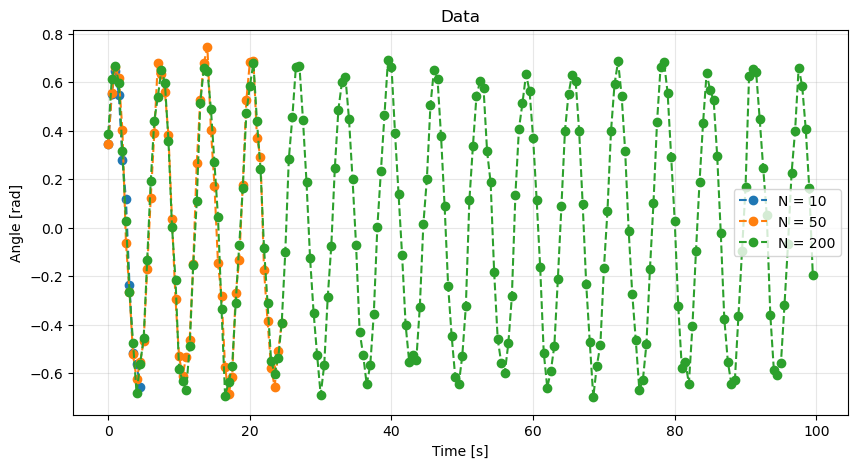

In [202]:
def pendulum_rhs_noise(t, y):
    g = 9.81      
    L = 1.0      
    m = 1.0      
    c = 0.0 
    theta, omega = y
    dtheta_dt = omega
    domega_dt = - (c / (m * L**2)) * omega - (g / L) * (theta)
    return [dtheta_dt, domega_dt] + np.random.randn(2) * 0.01

def pendulum_rhs_noise_discrete(Nt, y0):
    dt = 0.5
    Phi_true = dt * np.array([[0, 1.00],
                              [-0.95, 0]])
    Phi_true = scipy.linalg.expm(Phi_true)
    theta, omega = y0
    sol = np.zeros((int(Nt/dt), 2))
    sol[0] = np.array([theta, omega])
    for time in range(1, int(Nt/dt)):
        theta, omega = Phi_true @ np.array([theta, omega]) + np.random.randn(2) * 0.0025
        sol[time] = np.array([theta, omega])
    return np.arange(0, Nt, dt), sol


theta0 = np.pi / 8   
omega0 = 0.5
y0 = np.array([theta0, omega0])

datasets = {}
for N in [10, 50, 200]:
    #t_eval = np.arange(0, N * 0.1, 0.1)
    #sol = solve_ivp(pendulum_rhs_noise, (0, t_eval[-1]), y0, t_eval=t_eval)
    #datasets[f"{N}_points"] = {
    #    "t": sol.t,
    #    "y": sol.y.T + 0.05 * np.random.randn(len(sol.t), 2)
    #}
    t_eval, sol = pendulum_rhs_noise_discrete(N*0.5,y0)
    datasets[f"N = {N}"] = {
        "t": t_eval,
        "y": sol + 0.05 * np.random.randn(len(sol),2)
    }

plt.figure(figsize=(10, 5))
for label, data in datasets.items():
    plt.plot(data["t"], data["y"][:, 0], 'o--', label=f'{label}')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

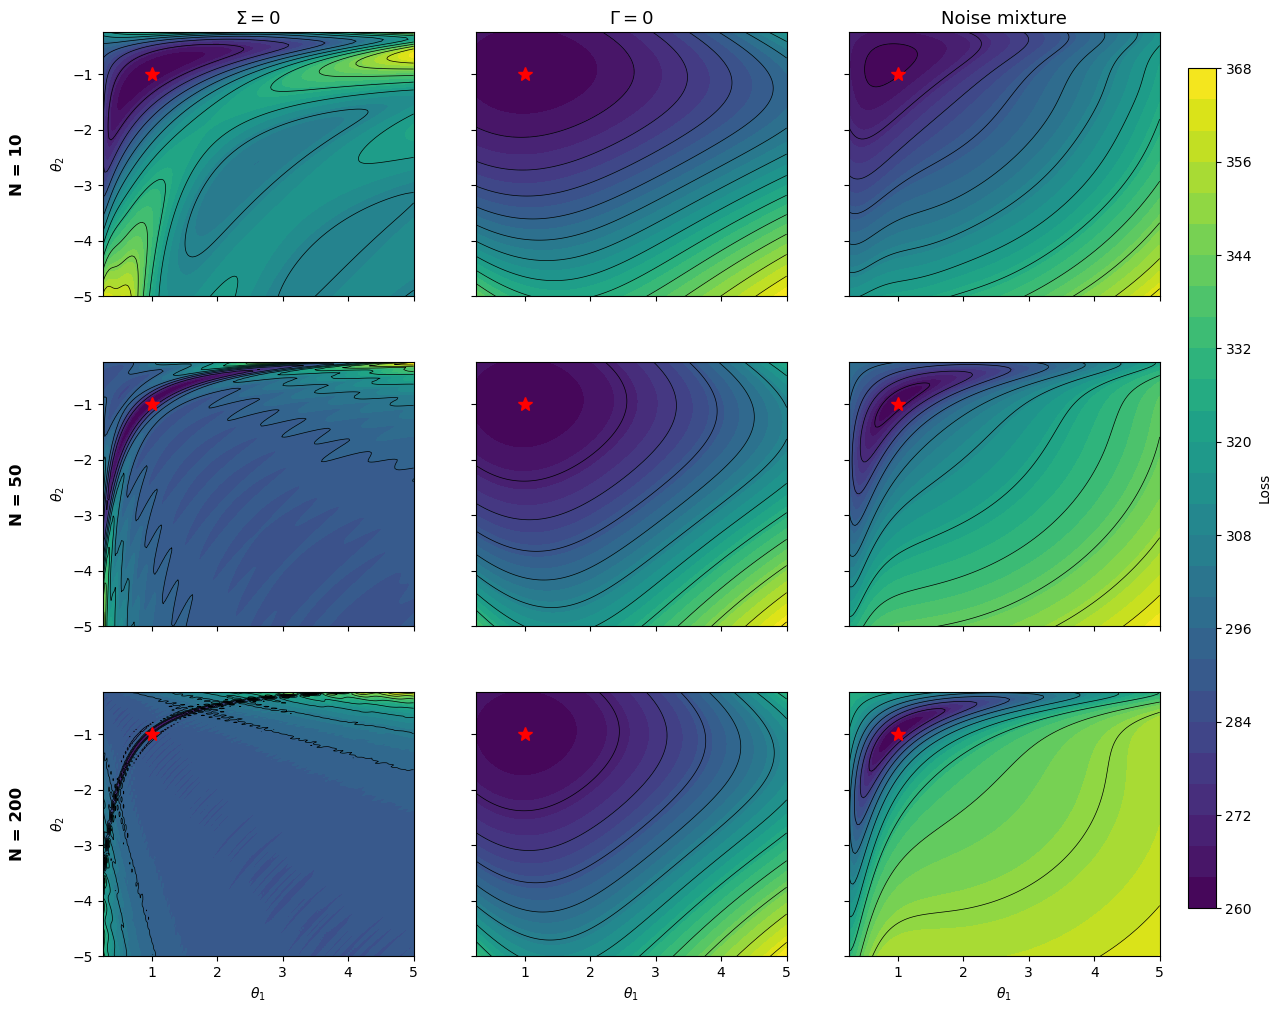

In [201]:

def dt_pendulum_rhs(t, x, theta):
    x1, x2 = x
    dx1_dt = theta[0] * x2
    dx2_dt = theta[1] * x1
    return [dx1_dt, dx2_dt]

def discrete_pendulum(y, theta):
    Phi = 0.5*np.array([[0, theta[0]], [theta[1], 0]])
    return scipy.linalg.expm(Phi) @ y


m0 = np.array([theta0, omega0])
P0 = 0.5**2 *np.eye(2)
def prior_logpdf(theta):
    return -0.5 * ((theta[0])**2 / 1.0**2 + (theta[1])**2 / 1.0**2)
def A(theta): 
    Phi = 0.5*np.array([[0, theta[0]], [theta[1], 0]])
    return scipy.linalg.expm(Phi)
def H(theta): return np.eye(2)
def Sigma(theta): return 0.01 * np.eye(2)
def Gamma(theta): return 0.5 * np.eye(2)

theta1_vals = np.linspace(0.25, 5.0, 150)
theta2_vals = np.linspace(-5.0, -0.25, 150)


fig, axes = plt.subplots(3, 3, figsize=(14, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.25, right=0.88)
cmap = 'viridis'

true_theta = (1.0, -1.0)
datasets_to_plot = ['N = 10', 'N = 50', 'N = 200']
loss_functions = ['loss_function_2', 'loss_function_3', 'linearkalman']

for row_idx, ds_name in enumerate(datasets_to_plot):
    data = datasets[ds_name]
    t = data['t']
    y = data['y']

    for col_idx, loss_type in enumerate(loss_functions):
        loss_grid = np.zeros((len(theta1_vals), len(theta2_vals)))

        for i, th1 in enumerate(theta1_vals):
            for j, th2 in enumerate(theta2_vals):
                theta = np.array([th1, th2])

                if loss_type == 'loss_function_2':
                    val = loss_function_2(theta, t, y, dt_pendulum_rhs, y0)
                elif loss_type == 'loss_function_3':
                    val = loss_function_3(theta, y, discrete_pendulum)
                elif loss_type == 'linearkalman':
                    res = linearkalman(theta, y, m0, P0, prior_logpdf, A, H, Sigma, Gamma)
                    val = -res['log_posterior']
                else:
                    val = np.nan

                loss_grid[i, j] = val

        X, Y = np.meshgrid(theta1_vals, theta2_vals)
        cont = axes[row_idx, col_idx].contourf(
            X, Y, loss_grid.T, levels=30, cmap=cmap
        )
        axes[row_idx, col_idx].contour(
            X, Y, loss_grid.T, levels=12, colors='k', linewidths=0.5
        )

        axes[row_idx, col_idx].plot(true_theta[0], true_theta[1], 'r*', markersize=10, label='True value')

        if row_idx == 2:
            axes[row_idx, col_idx].set_xlabel(r'$\theta_1$')
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(r'$\theta_2$')
        if row_idx == 0:
            if loss_type == 'loss_function_2':
                title = r"$\Sigma= 0$"
            elif loss_type == 'loss_function_3':
                title = r"$\Gamma = 0$"
            elif loss_type == 'linearkalman':
                title = "Noise mixture"
            axes[row_idx, col_idx].set_title(title, fontsize=13)

        axes[row_idx, col_idx].grid(False)

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(cont, cax=cbar_ax, label='Loss')

for i, ds_name in enumerate(datasets_to_plot):
    axes[i, 0].text(-0.25, 0.5, ds_name , transform=axes[i, 0].transAxes,
                    rotation=90, va='center', ha='right', fontsize=12, fontweight='bold')

plt.show()


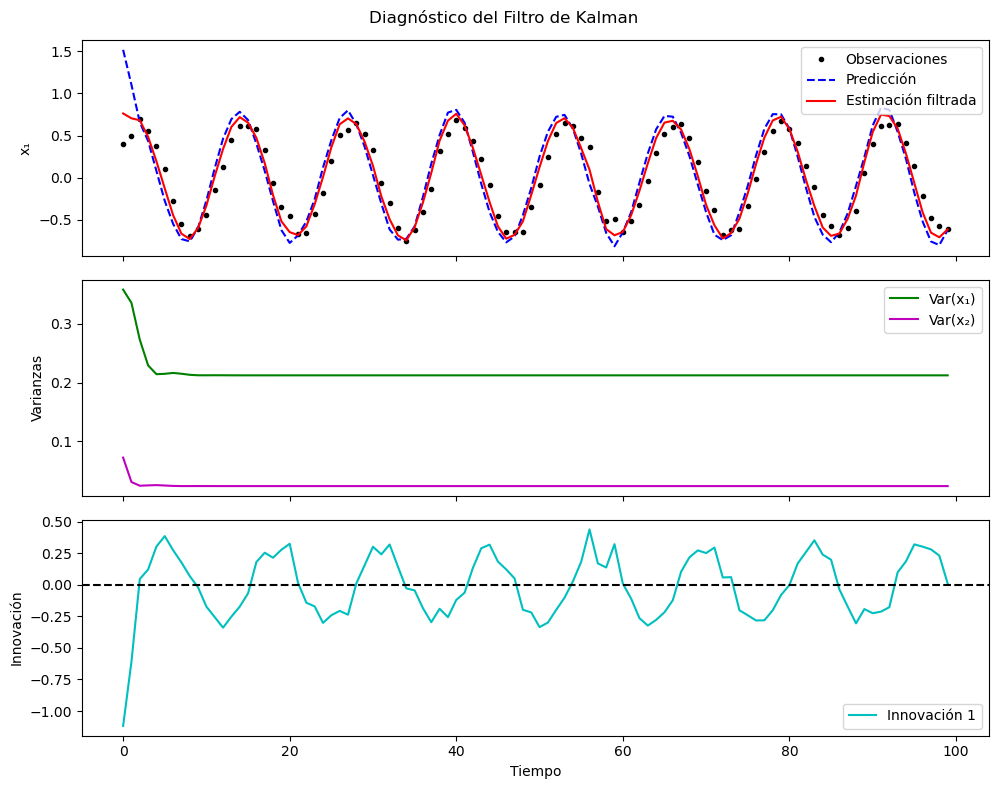

In [ ]:
import numpy as np
from scipy import linalg



res = linearkalman(theta, y, m0, P0, prior_logpdf, A, H, Sigma, Gamma)

m_pred = res['m_pred']
m_filt = res['m_filt']
P_filt = res['P_filt']
innov = res['innovation']

t = np.arange(len(y))

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# 1. Predicciones vs Observaciones
axs[0].plot(t, y[:, 0], 'k.', label='Observaciones')
axs[0].plot(t, m_pred[:, 0], 'b--', label='Predicción')
axs[0].plot(t, m_filt[:, 0], 'r-', label='Estimación filtrada')
axs[0].set_ylabel('x₁')
axs[0].legend()

# 2. Varianzas
axs[1].plot(t, [P[0,0] for P in P_filt], 'g', label='Var(x₁)')
axs[1].plot(t, [P[1,1] for P in P_filt], 'm', label='Var(x₂)')
axs[1].set_ylabel('Varianzas')
axs[1].legend()

# 3. Innovaciones
axs[2].plot(t, innov[:, 0], 'c', label='Innovación 1')
axs[2].axhline(0, color='k', linestyle='--')
axs[2].set_xlabel('Tiempo')
axs[2].set_ylabel('Innovación')
axs[2].legend()

plt.suptitle('Diagnóstico del Filtro de Kalman')
plt.tight_layout()
plt.show()


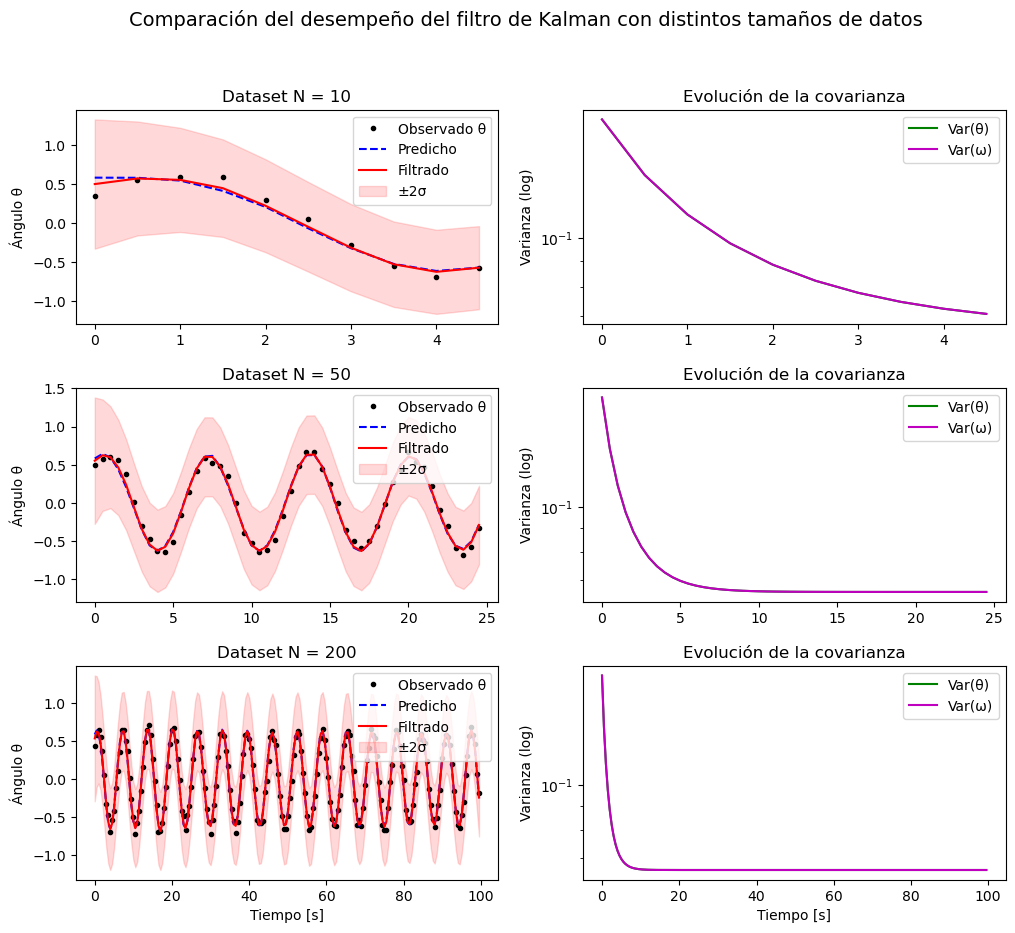

In [200]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)
datasets_to_plot = ['N = 10', 'N = 50', 'N = 200']

for i, ds_name in enumerate(datasets_to_plot):
    data = datasets[ds_name]
    t = data['t']
    y = data['y']

    # Corre el filtro
    res = linearkalman(
        theta=np.array([1.0, -1.0]),  # el valor verdadero
        Y=y,
        m0=m0,
        P0=P0,
        prior_logpdf=prior_logpdf,
        A_fn=A,
        H_fn=H,
        Sigma_fn=Sigma,
        Gamma_fn=Gamma
    )

    m_pred = res['m_pred']
    m_filt = res['m_filt']
    P_filt = res['P_filt']

    # ---------- Subplot 1: trayectoria ----------
    ax = axs[i, 0]
    ax.plot(t, y[:, 0], 'ko', markersize=3, label='Observado θ')
    ax.plot(t, m_pred[:, 0], 'b--', label='Predicho')
    ax.plot(t, m_filt[:, 0], 'r-', label='Filtrado')
    ax.fill_between(
        t,
        m_filt[:, 0] - 2*np.sqrt([P[0,0] for P in P_filt]),
        m_filt[:, 0] + 2*np.sqrt([P[0,0] for P in P_filt]),
        color='r', alpha=0.15, label='±2σ'
    )
    ax.set_title(f"Dataset {ds_name}")
    ax.set_ylabel("Ángulo θ")
    if i == 2:
        ax.set_xlabel("Tiempo [s]")
    ax.legend()

    # ---------- Subplot 2: evolución de la incertidumbre ----------
    ax = axs[i, 1]
    ax.plot(t, [P[0,0] for P in P_filt], 'g', label='Var(θ)')
    ax.plot(t, [P[1,1] for P in P_filt], 'm', label='Var(ω)')
    ax.set_yscale('log')
    ax.set_title("Evolución de la covarianza")
    if i == 2:
        ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Varianza (log)")
    ax.legend()

plt.suptitle("Comparación del desempeño del filtro de Kalman con distintos tamaños de datos", fontsize=14)
plt.show()


## Non linear pendulum

## Van der Pol

## Lorenz

## Reaction-diffusion